# Binary classification demo
As [described](https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data/data) on Kaggle, the data set has been synthetically enlarged using SMOTE. It may contain patterns that do not make "business sense". Here we will focus on showcasing data science techniques, as opposed to gaining a deep understanding of the data.

Let's assume the binary label `loan_status` indicates whether someone was approved for a loan; and that is what we will predict.

## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap

from functools import partial
from catboost import CatBoostClassifier
from optuna.samplers import TPESampler
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

# pandas's new option to reduce memory footprint and improve reproducibility
# https://pandas.pydata.org/docs/user_guide/copy_on_write.html#copy-on-write
pd.options.mode.copy_on_write = True

## Obtain and explore data
- Handle outliers
- Hunt for correlative and therefore potentially predictive features. 

### Load data

In [2]:
# Identified from Kaggle's data card
categorical_features = ["person_gender", "person_education", "person_home_ownership", "loan_intent", "previous_loan_defaults_on_file"]

# Load data using pyarrow for max speed
# Also, where applicable, encode as pandas Category to save memory
raw_data = pd.read_csv(
    "data/loan_data.csv",
    dtype_backend="pyarrow",
    engine="pyarrow",
    dtype={col: "category" for col in categorical_features},
)

# Check datatypes and nulls (None!)
display(raw_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype          
---  ------                          --------------  -----          
 0   person_age                      45000 non-null  double[pyarrow]
 1   person_gender                   45000 non-null  category       
 2   person_education                45000 non-null  category       
 3   person_income                   45000 non-null  double[pyarrow]
 4   person_emp_exp                  45000 non-null  int64[pyarrow] 
 5   person_home_ownership           45000 non-null  category       
 6   loan_amnt                       45000 non-null  double[pyarrow]
 7   loan_intent                     45000 non-null  category       
 8   loan_int_rate                   45000 non-null  double[pyarrow]
 9   loan_percent_income             45000 non-null  double[pyarrow]
 10  cb_person_cred_hist_length      45000 non-null  double[pya

None

In [3]:
# person_age and person_emp_exp have nonsensically large values
# For simplicity, I am filtering them out.
raw_data.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.0,45000.0,45000.0,45000.0,45000.0,45000.0,45000.0,45000.0,45000.0
mean,27.764178,80319.053222,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,80422.498632,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.0,8000.0,0.0,500.0,5.42,0.0,2.0,390.0,0.0
25%,24.0,47204.0,1.0,5000.0,8.59,0.07,3.0,601.0,0.0
50%,26.0,67048.0,4.0,8000.0,11.01,0.12,4.0,640.0,0.0
75%,30.0,95789.25,8.0,12237.25,12.99,0.19,8.0,670.0,0.0
max,144.0,7200766.0,125.0,35000.0,20.0,0.66,30.0,850.0,1.0


In [4]:
# Say, there's a policy of not lending to folks older than 90.
raw_data = raw_data.query("person_age <= 90")
raw_data.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,44992.0,44992.0,44992.0,44992.0,44992.0,44992.0,44992.0,44992.0,44992.0
mean,27.746955,79909.562678,5.392959,9583.245288,11.006448,0.139735,5.866087,632.582592,0.222262
std,5.901543,63322.3943,5.917871,6314.856103,2.979019,0.087207,3.87593,50.398623,0.415771
min,20.0,8000.0,0.0,500.0,5.42,0.0,2.0,390.0,0.0
25%,24.0,47197.25,1.0,5000.0,8.59,0.07,3.0,601.0,0.0
50%,26.0,67046.0,4.0,8000.0,11.01,0.12,4.0,640.0,0.0
75%,30.0,95779.0,8.0,12237.25,12.99,0.19,8.0,670.0,0.0
max,84.0,2448661.0,62.0,35000.0,20.0,0.66,30.0,784.0,1.0


In [26]:
TARGET_VAR = "loan_status"

numerical_features = raw_data.columns.difference([TARGET_VAR] + categorical_features).to_list()

X = raw_data[numerical_features + categorical_features]
y = raw_data[TARGET_VAR]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2)

### Numerical data
Check for correlation in-between numerical vars, because that can produce multicollinearity.

Text(0.5, 1.0, 'Spearman Correlation Matrix of Numerical Features')

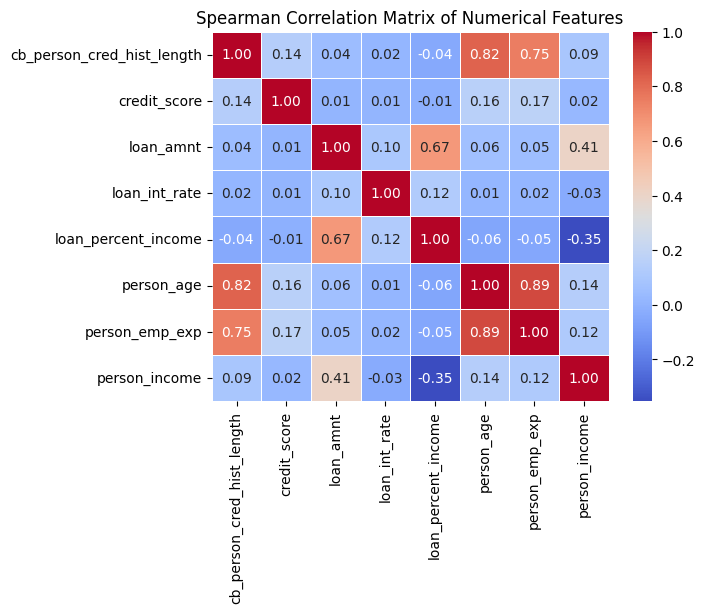

In [6]:
# Calculate the Spearman correlation matrix
# Spearman > Pearson, so that we capture non-linear relationships as well
correlation_matrix = raw_data[numerical_features].corr(method='spearman')
ax = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
ax.set_title('Spearman Correlation Matrix of Numerical Features')

Check for correlation between numerical vars and target. 

For example, there appears to be only a weak correlation between `loan_status` and the features
- `cb_person_cred_hist_length`
- `person_age`

We may consider excluding this feature from a 1st pass model. For now, let's include them and let SHAP determine whether they are useful.

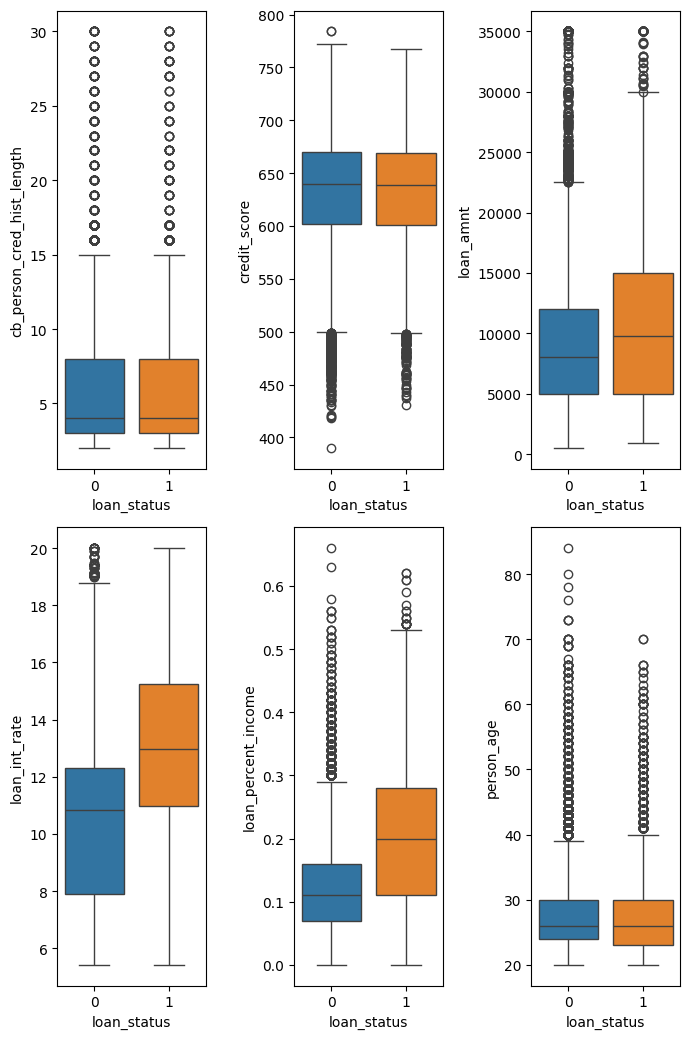

In [7]:
# Subplot the boxtplots into a grid with two columns
fig, axes = plt.subplots(len(numerical_features) // 3, 3, figsize=(7, 10.5), tight_layout=True) # Adjust figsize as needed

for ax, feature in zip(axes.flatten(), numerical_features):
   sns.boxplot(x=TARGET_VAR, y=feature, data=raw_data, ax=ax, hue=TARGET_VAR)
   ax.set_xlabel(TARGET_VAR)
   ax.set_ylabel(feature)
   # ax.tick_params(axis='y', labelsize=10) # Adjust label size if needed
   ax.get_legend().remove()

### Categorical data
Check if each unique values of each categorical var correspond to different distributions of the target variable.

For example, `person_gender` and `person_education` seem to have the same distributions across both values of `loan_amount`. Their utility as ML features may be limited.

In [ ]:
for col in categorical_features:
    print(col)
    display(
        raw_data.groupby(col, observed=True)[TARGET_VAR]
        .value_counts(normalize=True)
        .round(2)
    )

person_gender


person_gender  loan_status
female         0              0.78
               1              0.22
male           0              0.78
               1              0.22
Name: proportion, dtype: double[pyarrow]

person_education


person_education  loan_status
Associate         0              0.78
                  1              0.22
Bachelor          0              0.77
                  1              0.23
Doctorate         0              0.77
                  1              0.23
High School       0              0.78
                  1              0.22
Master            0              0.78
                  1              0.22
Name: proportion, dtype: double[pyarrow]

person_home_ownership


person_home_ownership  loan_status
MORTGAGE               0              0.88
                       1              0.12
OTHER                  0              0.67
                       1              0.33
OWN                    0              0.92
                       1              0.08
RENT                   0              0.68
                       1              0.32
Name: proportion, dtype: double[pyarrow]

loan_intent


loan_intent        loan_status
DEBTCONSOLIDATION  0               0.7
                   1               0.3
EDUCATION          0              0.83
                   1              0.17
HOMEIMPROVEMENT    0              0.74
                   1              0.26
MEDICAL            0              0.72
                   1              0.28
PERSONAL           0               0.8
                   1               0.2
VENTURE            0              0.86
                   1              0.14
Name: proportion, dtype: double[pyarrow]

previous_loan_defaults_on_file


previous_loan_defaults_on_file  loan_status
No                              0              0.55
                                1              0.45
Yes                             0               1.0
Name: proportion, dtype: double[pyarrow]

## Train and evaluate models

Regarding feature engineering, note that libraries like [XGBoost](https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html), [CatBoost](https://catboost.ai/docs/en/features/categorical-features), and [LightGBM](https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#categorical-feature-support) handle numerical and categorical features without explicit scaling or encoding. With approximately 45k observations, boosting models are suitable.

For smaller datasets (e.g., 10x less data), logistic regression might be a better choice.

Which evaluation metrics should we use? Since the target label is not particularly imbalanced, we can consider accuracy in addition to precision and recall. 

I imagine for the purpose of determining whether someone should get a loan, precision is more important because we don't want to approve loans that are likely to default.

### Baseline performance
How well would we do, if we were to naively guess the most frequent class? Any model that we build must exceed this level of performance.

In [ ]:
# Assuming y_test is a numpy array of 0s and 1s
# Example: y_test = np.array([0, 1, 0, 0, 1, 1, 0])

# Find the most frequent value in y_test
naive_y_pred = np.full_like(y_test, np.argmax(np.bincount(y_test)))
print(classification_report(y_test, naive_y_pred))

              precision    recall  f1-score   support

         0.0       0.78      1.00      0.87      6996
         1.0       0.00      0.00      0.00      2003

    accuracy                           0.78      8999
   macro avg       0.39      0.50      0.44      8999
weighted avg       0.60      0.78      0.68      8999



/Users/everestlaw/Library/Caches/pypoetry/virtualenvs/data-science-good-practices-demo-NBjP4iyU-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/everestlaw/Library/Caches/pypoetry/virtualenvs/data-science-good-practices-demo-NBjP4iyU-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/everestlaw/Library/Caches/pypoetry/virtualenvs/data-science-good-practices-demo-NBjP4iyU-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

### Gradient boosting

In [ ]:
CatBoostClassifier_binary = partial(
    CatBoostClassifier,
    cat_features=categorical_features,
    verbose=0,
    loss_function="Logloss",
)

baseline_clf = CatBoostClassifier_binary().fit(X_train, y_train)
baseline_y_pred = baseline_clf.predict(X_test)
print(classification_report(y_test, baseline_y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96      6996
         1.0       0.89      0.80      0.84      2003

    accuracy                           0.93      8999
   macro avg       0.92      0.88      0.90      8999
weighted avg       0.93      0.93      0.93      8999



In [ ]:
#Use Optuna to find the best hyperparameters
def optuna_objective(trial: optuna.Trial) -> float:
    model = CatBoostClassifier_binary(
        iterations=trial.suggest_int("iterations", 80, 400),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 3, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 1, 10),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

In [36]:
#Create the study
optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = TPESampler(seed=None)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(optuna_objective, n_trials=100)

In [ ]:
# Didn't beat untuned model!

tuned_clf = CatBoostClassifier_binary(**study.best_params).fit(X_train, y_train)
tuned_y_pred = tuned_clf.predict(X_test)
print(classification_report(y_test, tuned_y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96      6996
         1.0       0.89      0.79      0.84      2003

    accuracy                           0.93      8999
   macro avg       0.92      0.88      0.90      8999
weighted avg       0.93      0.93      0.93      8999



In [ ]:
# For a 2nd pass, this plot can help us tune less parameters, and therefore arrive at an optimized model more quickly
optuna.visualization.plot_param_importances(study)

In [ ]:
# # Define model with best hyperparams, and possibly train it
# best_clf = CatBoostClassifier(cat_features=categorical_features, verbose=0, loss_function='logloss', **study.best_params)

## Crack open the model blackbox
After making sure that the model generalizes well, we can interpret its predictions using SHAP values. This will help us understand which features drove the model's decisions.

Since the untuned catboost classifier is already doing well, let's apply SHAP to it.

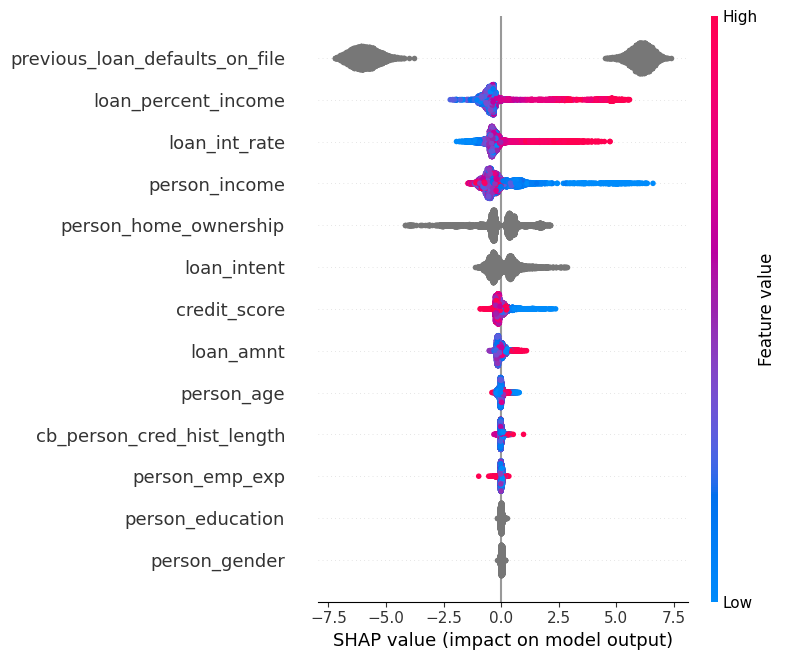

In [ ]:
explainer = shap.TreeExplainer(baseline_clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

And indeed --- the features identified during EDA as "weakly correlated with target" are contributing minimally to predictions!